# Case Adevinta Data Analyst

My approach is to solve the case with SQL but taking advantage of the flexibility and simplicity that Python provides. I will use SQL Lite to create the connector and to store the table and Pandas to execute queries on SQL. Also, matplotlib will be used for plotting purposes.

I will start by loading the corresponding libraries. 

In [ ]:
import sqlite3 as sql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's load the table *events_log.csv* from the source.

In [2]:
url ='https://github.com/wikimedia-research/Discovery-Hiring-Analyst-2016/blob/master/events_log.csv.gz?raw=true'
log = pd.read_csv(url, compression = 'gzip')

Let's transform the column *timestamp* to date time values.

In [ ]:
log['timestamp'] = pd.to_datetime(log['timestamp'], format='%Y%m%d%H%M%S')

We will create the *conn* object to let query SQL in our source file *events_log.csv*. 
The SQL table referencing *events_log.csv* is called *events*.

In [4]:
conn = sql.connect('log.db')
log.to_sql('events', conn)

First of all, we are going to analyze our dataset in order to best understand the data.
We will start analyzing the main characteristic such as data type per column, data count, nulls count and memory use. 

In [56]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400165 entries, 0 to 400164
Data columns (total 9 columns):
uuid               400165 non-null object
timestamp          400165 non-null datetime64[ns]
session_id         400165 non-null object
group              400165 non-null object
action             400165 non-null object
checkin            223824 non-null float64
page_id            400165 non-null object
n_results          136234 non-null float64
result_position    230482 non-null float64
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 27.5+ MB


Also, we will perform a statistical analysis in order to better understand the range and mean values of our dataset: 

In [57]:
log.describe()

,checkin,n_results,result_position
count,223824.000000,136234.000000,230482.000000
mean,97.190382,13.210109,2.992798
std,104.593714,13.271104,38.557292
min,10.000000,0.000000,1.000000
25%,20.000000,2.000000,1.000000
50%,50.000000,20.000000,1.000000
75%,150.000000,20.000000,2.000000
max,420.000000,500.000000,4103.000000


Also, we will check the uniqueness of some key columns data:

**Is uuid unique, so I doesn't have any duplicate?**

In [41]:
unique_uuid = pd.read_sql('''

SELECT 
    COUNT(*) - COUNT(DISTINCT uuid) AS Duplicate_uuid 
FROM events

''', conn)

Yes, uuid is unique.

In [8]:
unique_uuid.head()

,Duplicate_uuid
0,0


**Is the total number of different groups really equal to 2?**

In [42]:
num_group = pd.read_sql('''

SELECT 
    COUNT(DISTINCT "group") AS Groups_Number 
FROM events

''', conn)

Yes, the total number of different groups is 2.

In [43]:
print(num_group)

   Groups_Number
0              2


## 1. Clickthrough Rate Calculation

**What is our daily overall clickthrough rate? How does it vary between the groups?**

The daily overall clickthrough rate is defined as the ratio between all the sessions that click on a displayed search result among all the sessions. We will take a special consideration to the case in which a session is created one day but the click is performed in other day, that's why we are going to perform the analysis between the mininum timestamp of a session (when it is created) and maximum timestamp of a session (when it finishes).

In [44]:
conversion_rate = pd.read_sql('''

        WITH A AS(
            SELECT 
                "group"
                ,session_id
                ,MIN(date(timestamp)) AS Day_Start
                ,MAX(CASE WHEN action == "visitPage" THEN 1 ELSE 0 END) AS Has_Clicked 
            FROM events 
            GROUP BY 1,2 
            ORDER BY 1,2,3
            ) 
        SELECT 
            Day_Start
            ,1.00000*SUM(Has_Clicked)/COUNT(session_id) AS Conversion_Rate 
        FROM A  
        GROUP BY 1 
        ORDER BY 1
    
    ''',conn) 

**Daily overall clickthrough rate**

In [45]:
conversion_rate.head(10)

,Day_Start,Conversion_Rate
0,2016-03-01,0.380670
1,2016-03-02,0.391219
2,2016-03-03,0.387884
3,2016-03-04,0.398495
4,2016-03-05,0.382226
5,2016-03-06,0.388474
6,2016-03-07,0.392636
7,2016-03-08,0.388126


Now, we will split the conversion rate results among the two different groups (a and b)

**Daily overall clickthrough rate per group**

In [46]:
conversion_rate_group = pd.read_sql('''

        WITH A AS(
            SELECT 
                "group"
                ,session_id
                ,MIN(date(timestamp)) AS Day_Start
                ,MAX(CASE WHEN action == "visitPage" THEN 1 ELSE 0 END) AS Has_Clicked 
            FROM events GROUP BY 1,2 ORDER BY 1,2,3
            ) 
        SELECT 
            Day_Start
            ,"group"
            ,1.00000*SUM(Has_Clicked)/COUNT(session_id) AS Conversion_Rate 
        FROM A  
        GROUP BY 1,2 
        ORDER BY 1,2
    
    ''',conn) 

In [90]:
conversion_rate_group.head(10)

,Day_Start,group,Conversion_Rate
0,2016-03-01,a,0.671259
1,2016-03-01,b,0.138416
2,2016-03-02,a,0.682250
3,2016-03-02,b,0.145349
4,2016-03-03,a,0.676828
5,2016-03-03,b,0.152022
6,2016-03-04,a,0.676269
7,2016-03-04,b,0.192819
8,2016-03-05,a,0.646131
9,2016-03-05,b,0.202399


## 2. Best Search Result

**Which results do people tend to try first? How does it change day-to-day?**

To analyze the results people tend to try first, we will take into account data that meets the following criteria:

* Sessions with a current action equal to *visitPage*
* Sessions with a previous action equal to *searchResultPage*
* Sessions with equal current and previous *session_id*

So, we will analyze sessions that perform a search result page action and visit page action in two equal session_id consecutive sessions. Then, from these sessions we will count totals for the different result positions and its corresponding ratios in order to find the search results tendency.

In [50]:
best_search_result = pd.read_sql('''

        WITH B AS (
            SELECT 
                timestamp
                ,session_id
                ,LAG(session_id,1,0) OVER(PARTITION BY session_id) AS Previous_Session
                ,action
                ,LAG(action,1,0) OVER() AS Previous_Action
                ,result_position 
            FROM events 
            GROUP BY 2,1 
            ORDER BY 2,1
            ), 
        C AS (
            SELECT 
                date(timestamp)
                ,session_id
                ,result_position 
            FROM B 
            WHERE session_id == Previous_Session 
                AND action == "visitPage" 
                AND Previous_Action == "searchResultPage" 
            ORDER BY 2
            ) 
        SELECT 
            result_position
            ,COUNT(result_position) AS Preferred_Search_Result
            ,1.00000*COUNT(result_position)/(SELECT COUNT(*) FROM C) AS Preferred_Search_Ratio 
        FROM C 
        GROUP BY 1 
        ORDER BY 1 
        
''',conn)

**Best Search Result**
As we can see in the results below, the search result that users tend to try first is the result in position 1.

In [51]:
best_search_result[1:6]

,result_position,Preferred_Search_Result,Preferred_Search_Ratio
1,1.0,20973,0.633033
2,2.0,4685,0.141408
3,3.0,2381,0.071866
4,4.0,1298,0.039178
5,5.0,817,0.024660


Now, let's split the results per day:

In [86]:
best_search_result_daily = pd.read_sql('''
        
        WITH B AS (
            SELECT 
                timestamp
                ,session_id
                ,LAG(session_id,1,0) OVER(PARTITION BY session_id) AS Previous_Session
                ,action
                ,LAG(action,1,0) OVER() AS Previous_Action
                ,result_position 
            FROM events 
            GROUP BY 2,1 
            ORDER BY 2,1
            ), 
        C AS (
            SELECT 
                date(timestamp) AS Date
                ,session_id
                ,result_position 
            FROM B 
            WHERE session_id == Previous_Session 
                AND action == "visitPage" 
                AND Previous_Action == "searchResultPage" 
            ORDER BY 2
            ),
        D AS (
 
            SELECT 
                Date
                ,result_position
                ,COUNT(result_position) AS Total_results_date 
            FROM C 
            GROUP BY 1,2 
            ORDER BY 1,2
            )
            
            SELECT
                Date
                ,result_position
                ,1.00000*MAX(Total_results_date) / SUM(Total_results_date) AS Preferred_Search_Ratio_PerDay
            FROM D
            GROUP BY 1
            ORDER BY 1     
    
    ''' ,conn)

**Best Search Result Daily**

In [87]:
best_search_result_daily.head(10)

,Date,result_position,Preferred_Search_Ratio_PerDay
0,2016-03-01,1.0,0.642398
1,2016-03-02,1.0,0.629505
2,2016-03-03,1.0,0.631714
3,2016-03-04,1.0,0.634473
4,2016-03-05,1.0,0.625039
5,2016-03-06,1.0,0.630719
6,2016-03-07,1.0,0.636086
7,2016-03-08,1.0,0.632705


## 3. Total Zeros

**What is our daily overall zero results rate? How does it vary between the groups?**

Daily overall zeros results rate is the proportion of successfull search result page actions with zero result that day. 

In [52]:
total_zeros = pd.read_sql('''

        WITH T AS (
            SELECT 
                date(timestamp) AS Date
                ,"group"
                ,action
                ,page_id
                ,CASE WHEN n_results == 0 AND action == "searchResultPage" THEN 1 ELSE 0 END AS Num_Zeros 
            FROM events
            ) 
        SELECT 
            Date
            ,SUM(Num_Zeros) AS Total_Zeros
            ,(1.00000)*SUM(Num_Zeros)/COUNT(page_id) AS Total_Zeros_Rate 
        FROM T 
        WHERE action == "searchResultPage" 
        GROUP BY 1 
        ORDER BY 1 

''',conn)

**Daily overall zero results rate**

In [53]:
total_zeros.head(10)

,Date,Total_Zeros,Total_Zeros_Rate
0,2016-03-01,3447,0.187602
1,2016-03-02,3589,0.189874
2,2016-03-03,3443,0.179707
3,2016-03-04,3015,0.180810
4,2016-03-05,2442,0.184944
5,2016-03-06,2574,0.176157
6,2016-03-07,3460,0.182000
7,2016-03-08,3157,0.193717


In [ ]:
Now, let's split the results per group:

In [54]:
total_zeros_group = pd.read_sql('''

        WITH T AS (
            SELECT 
                date(timestamp) AS Date
                ,"group"
                ,action
                ,page_id
                ,CASE WHEN n_results == 0 AND action == "searchResultPage" THEN 1 ELSE 0 END AS Num_Zeros 
            FROM events
            ) 
        SELECT 
            Date
            ,"group"
            ,SUM(Num_Zeros) AS Total_Zeros_Group
            ,(1.00000)*SUM(Num_Zeros)/COUNT(page_id) AS Total_Zeros_Group_Rate 
        FROM T WHERE action == "searchResultPage" 
        GROUP BY 1,2 
        ORDER BY 1,2 
        
''',conn)

**Daily overall zero results rate per group**

In [55]:
total_zeros_group.head(10)

,Date,group,Total_Zeros_Group,Total_Zeros_Group_Rate
0,2016-03-01,a,2350,0.186775
1,2016-03-01,b,1097,0.189399
2,2016-03-02,a,2524,0.191082
3,2016-03-02,b,1065,0.187072
4,2016-03-03,a,2371,0.178539
5,2016-03-03,b,1072,0.182344
6,2016-03-04,a,2068,0.183041
7,2016-03-04,b,947,0.176121
8,2016-03-05,a,1535,0.178240
9,2016-03-05,b,907,0.197517


## 4. Session length vs Total Search Results

**Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.**

For the purpose of this question, we will analyze the relationship between session length and the total number of results displayed to a session.

In [88]:
session_length = pd.read_sql('''

        SELECT 
            session_id
            ,strftime("%s",MAX(timestamp)) - strftime("%s",MIN(timestamp)) AS Session_Length_seconds
            ,SUM(n_results) AS Total_results 
        FROM events 
        GROUP BY 1  
        ORDER BY 1
        
''',conn)

In [89]:
session_length.head(10)

,session_id,Session_Length_seconds,Total_results
0,0000cbcb67c19c45,0,20.0
1,0001382e027b2ea4,303,18.0
2,0001e8bb90445cb2,435,20.0
3,000216cf18ae1ab1,58,120.0
4,000527f711d50dfc,0,1.0
5,00064fe774048046,43,1.0
6,00071a2cf97168df,0,20.0
7,0007582fe23d51e6,0,0.0
8,0007b7f6b575feb6,339,20.0
9,00086b6ff8156928,0,0.0


As we can see in the results below, the correlation between both variables is 0.064885. So, we can conclude session length and total search results displayed are not correlated. 

In [35]:
session_length.corr()

,Session_Length_seconds,Total_results
Session_Length_seconds,1.000000,0.064885
Total_results,0.064885,1.000000


Let's visualize the results, that confirm our conclusion.

Text(0.5, 1.0, 'Results vs Session Length')

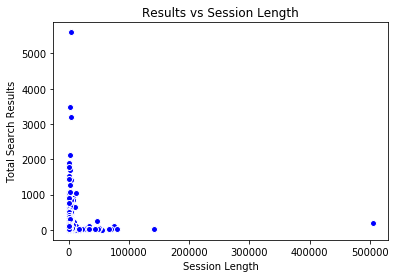

In [36]:
plt.scatter(session_length.Session_Length_seconds,session_length.Total_results, c='blue',edgecolors= "white")
plt.xlabel('Session Length')
plt.ylabel('Total Search Results')
plt.title('Results vs Session Length')

Now, we are going to redefine our hypothesis removing data outliers. In our case, we don't know the maximum time
a user should be actively navigating but we can estimate it.
Sessions with length higher than one hour doesn't have too much sense so we are going to create a new hyphotesis and restrict our data removing all those sessions with length higher than 3600 seconds. 

In [58]:
session_length_restricted = session_length[(session_length['Session_Length_seconds'] < 3600)]

In [59]:
session_length_restricted.corr()

,Session_Length_seconds,Total_results
Session_Length_seconds,1.00000,0.40947
Total_results,0.40947,1.00000


Now, the relationship among both variables is quite better (0.41). 
Let's visualize the results:

Text(0.5, 1.0, 'Results vs Session Length (Session Length Restricted)')

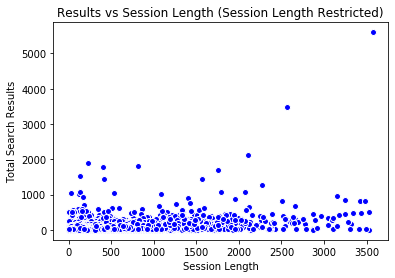

In [74]:
plt.scatter(session_length_restricted.Session_Length_seconds,session_length_restricted.Total_results, c='blue',edgecolors= "white")
plt.xlabel('Session Length')
plt.ylabel('Total Search Results')
plt.title('Results vs Session Length (Session Length Restricted)')

Finally, we are going to introduce a new hypothesis. In the real world, sessions with high search results values could be suspicious as could be related to some scrapping bots that perform the searches automatically. 
That's why we are going to restrict the total results possible performed by a session to 100.

In [69]:
session_length_results_restricted = session_length[(session_length['Total_results'] < 100) & 
                                                   (session_length['Session_Length_seconds'] < 3600)]

In [70]:
session_length_results_restricted.corr()

,Session_Length_seconds,Total_results
Session_Length_seconds,1.000000,0.325975
Total_results,0.325975,1.000000


Text(0.5, 1.0, 'Results vs Session Length (Num Results and Session Length restricted)')

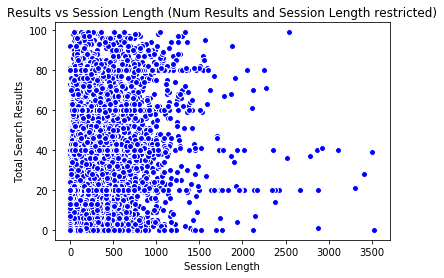

In [73]:
plt.scatter(session_length_results_restricted.Session_Length_seconds,session_length_results_restricted.Total_results, 
            c='blue',edgecolors= "white")
plt.xlabel('Session Length')
plt.ylabel('Total Search Results')
plt.title('Results vs Session Length (Num Results and Session Length restricted)')

In this new scenario, we can see both variables are also quite good correlated. 
Also, is interesting to mention that results have the tendency to appear aggregated in multiples of 20 (20, 40, 60,...).

## 5. Executive Summary

**Summarize your findings in an executive summary.**

On average, the clickthrough rate is around 40% during the 8 days exposed in the dataset.
Clearly, group *a* is more engaged with a higher clickthrough rate compared to group *b* (65% - 68% for group *a* comparted to 14% - 20% for group *b*). Those differences are maintained along time.

Users have a clear preference for the first search result with a ratio of 63% of clicks converted.
This tendency is constant along each day in the series.

Total zeros rate is quite constant along all the days provided by the dataset with values ranging between 17% and 20%. Also, there is not any important difference between the two groups (*a* and *b*).

In general, for further analysis, a wider time range should be provided.

Finally, taking into account all the sessions in the dataset, the variables *session length* and *total number of results* doesn't have a significant relationship buf if we restrict the dataset to the more significant sessions, we can see a positive relationship among the two variables. Also, is important to mention that most of the searches have its results grouped in constant intervals of 20 (20, 40, 60, ...).